# Part 1: Visual Document Search with ColQwen and Elasticsearch `rank_vectors`

This notebook demonstrates how to reproduce and enhance the concepts from the Elastic Search Labs blog post '[Searching complex documents with ColPali](https://www.elastic.co/search-labs/blog/elastiacsearch-colpali-document-search)'.

**Key Enhancements:**
1.  **Model Upgrade**: We use the **`tsystems/colqwen2.5-3b-multilingual-v1.0`** model, a top-performing model on the ViDoRe benchmark.
2.  **Real-world Dataset**: We use sample images from the **RVL-CDIP** dataset to demonstrate capabilities on complex, real-world documents.
3.  **Robust Connection Logic**: The connection logic automatically detects whether the environment variable specifies a **Cloud ID** or a **Host URL**, ensuring a stable connection.

### Step 0: Setup Environment

**[EN]** Install the necessary libraries.<br>
**[KR]** 필요한 라이브러리를 설치합니다.

In [ ]:
!pip install -q "git+https://github.com/illuin-tech/colpali.git"
!pip install -q "transformers>=4.41.0" accelerate Pillow elasticsearch python-dotenv tqdm

### Step 1: Import Libraries and Set Environment Variables

**[EN]** Import necessary libraries and load environment variables from the `elastic.env` file.<br>
**[KR]** 필요한 라이브러리를 임포트하고, `elastic.env` 파일에서 환경 변수를 로드합니다.

In [ ]:
import torch
import os
import glob
import base64
from io import BytesIO
from tqdm.notebook import tqdm
from PIL import Image
from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from IPython.display import display, HTML

dotenv_path = 'elastic.env'
load_dotenv(dotenv_path=dotenv_path)

ELASTIC_HOST = os.getenv("ELASTIC_HOST")
ELASTIC_API_KEY = os.getenv("ELASTIC_API_KEY")

if not ELASTIC_HOST or not ELASTIC_API_KEY:
    raise ValueError(f"Please ensure '{dotenv_path}' contains ELASTIC_HOST and ELASTIC_API_KEY.")

INDEX_NAME = "colqwen-rvlcdip-demo-part1"
VECTOR_FIELD_NAME = "colqwen_vectors"
SAMPLED_DATA_DIR = "samples"

### Step 2: Load the ColQwen Model

**[EN]** Load the `tsystems/colqwen2.5-3b-multilingual-v1.0` model and its processor.<br>
**[KR]** `tsystems/colqwen2.5-3b-multilingual-v1.0` 모델과 프로세서를 로드합니다.

In [ ]:
from colpali_engine.models import ColQwen2_5, ColQwen2_5_Processor

device_map = "cpu"
if torch.backends.mps.is_available():
    device_map = "mps"
elif torch.cuda.is_available():
    device_map = "cuda:0"
print(f"Using device: {device_map}")

MODEL_NAME = "tsystems/colqwen2.5-3b-multilingual-v1.0"
model = ColQwen2_5.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device_map != "cpu" else torch.float32,
    device_map=device_map
).eval()
processor = ColQwen2_5_Processor.from_pretrained(MODEL_NAME)
print(f"Model '{MODEL_NAME}' loaded successfully on device '{model.device}'.")

### Step 3: Load RVL-CDIP Sample Data

**[EN]** Load the list of RVL-CDIP sample image files from the `samples` directory.<br>
**[KR]** `samples` 디렉터리에서 RVL-CDIP 샘플 이미지 파일 목록을 가져옵니다.

In [ ]:
if not os.path.exists(SAMPLED_DATA_DIR):
    raise FileNotFoundError(f"Sample data directory not found at '{SAMPLED_DATA_DIR}'. Please create it in the same directory as this notebook.")

image_paths = []
for category_dir in os.listdir(SAMPLED_DATA_DIR):
    full_category_path = os.path.join(SAMPLED_DATA_DIR, category_dir)
    if os.path.isdir(full_category_path):
        image_paths.extend(glob.glob(os.path.join(full_category_path, '*.*')))
print(f"Found {len(image_paths)} sample images.")

### Step 4: Define Embedding Helper Functions

**[EN]** Define helper functions to generate multi-vector embeddings for document images and text queries.<br>
**[KR]** 문서 이미지와 텍스트 질의의 다중 벡터 임베딩을 생성하는 함수를 정의합니다.

In [ ]:
def create_colqwen_document_vectors(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor.process_images([image]).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.cpu().to(torch.float32).numpy().tolist()[0]
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def create_colqwen_query_vectors(query_text):
    inputs = processor.process_queries([query_text]).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.cpu().to(torch.float32).numpy().tolist()[0]

### Step 5: Connect to Elasticsearch and Create an Index

**[EN]** Connect to Elasticsearch and create an index with a `rank_vectors` field.<br>
**[KR]** Elasticsearch에 연결하고 `rank_vectors` 필드를 포함하는 인덱스를 생성합니다.

In [ ]:
# Automatically detect if ELASTIC_HOST is a Cloud ID or a Host URL.
if ':' in ELASTIC_HOST and not ELASTIC_HOST.startswith('http'):
    # Connect using Cloud ID
    print("Connecting using Cloud ID...")
    es = Elasticsearch(
        cloud_id=ELASTIC_HOST,
        api_key=ELASTIC_API_KEY
    )
else:
    # Connect using Host URL
    print("Connecting using Host URL...")
    es = Elasticsearch(
        hosts=[ELASTIC_HOST],
        api_key=ELASTIC_API_KEY
    )

print(f"Connected to Elasticsearch version: {es.info()['version']['number']}")

if es.indices.exists(index=INDEX_NAME):
    es.indices.delete(index=INDEX_NAME)
    print(f"Deleted existing index: {INDEX_NAME}")

mapping = {
    "properties": {
        VECTOR_FIELD_NAME: {"type": "rank_vectors", "dims": 128},
        "image_path": {"type": "keyword"},
        "category": {"type": "keyword"}
    }
}
es.indices.create(index=INDEX_NAME, mappings=mapping)
print(f"Created index '{INDEX_NAME}' with 'rank_vectors' field.")

### Step 6: Index the Data

**[EN]** Index the loaded sample images into Elasticsearch.<br>
**[KR]** 로드된 샘플 이미지들을 Elasticsearch에 인덱싱합니다.

In [ ]:
MAX_DOCS_TO_INDEX = 1600
docs_to_index = image_paths[:min(len(image_paths), MAX_DOCS_TO_INDEX)]
print(f"Indexing {len(docs_to_index)} documents into '{INDEX_NAME}'...")

for path in tqdm(docs_to_index, desc="Indexing Documents"):
    doc_id = os.path.splitext(os.path.basename(path))[0]
    category = os.path.basename(os.path.dirname(path))
    vectors = create_colqwen_document_vectors(path)
    
    if vectors:
        es_doc = {
            VECTOR_FIELD_NAME: vectors,
            "image_path": path,
            "category": category
        }
        es.index(index=INDEX_NAME, id=doc_id, document=es_doc)

es.indices.refresh(index=INDEX_NAME)
print("\nIndexing complete.")

### Step 7: Search and Visualize Results

**[EN]** Perform a search using `script_score` and `maxSimDotProduct` and visualize the results.<br>
**[KR]** `script_score`와 `maxSimDotProduct`를 사용하여 검색을 수행하고 결과를 시각화합니다.


Searching for: 'Do you have a benefits policy change notice from HR?'



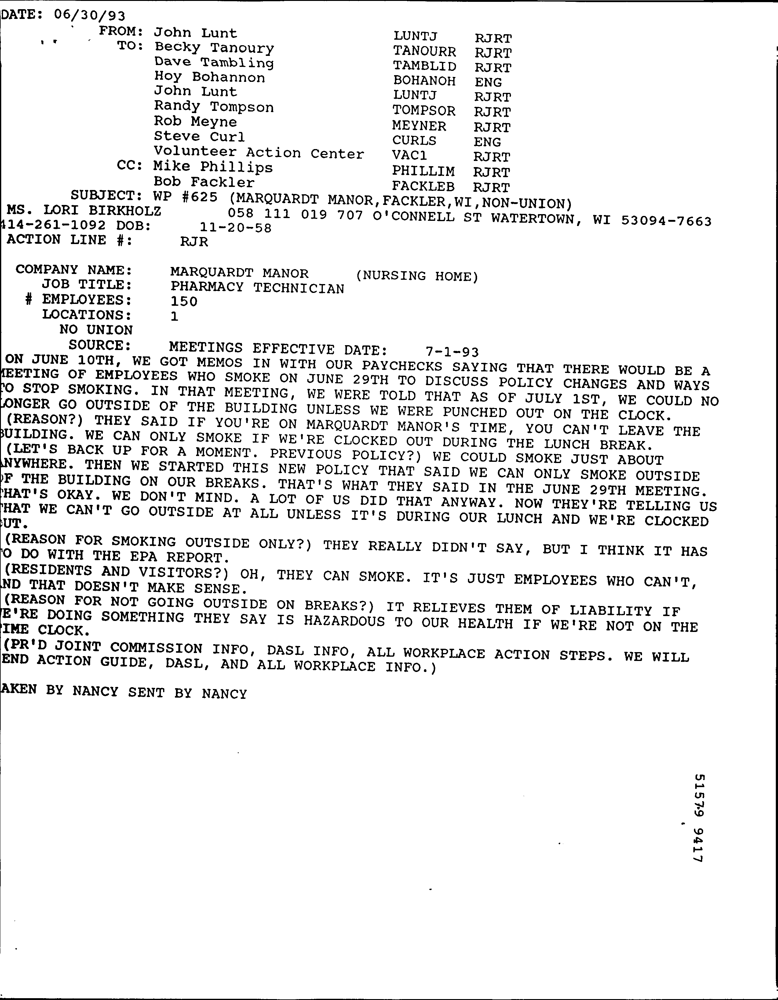
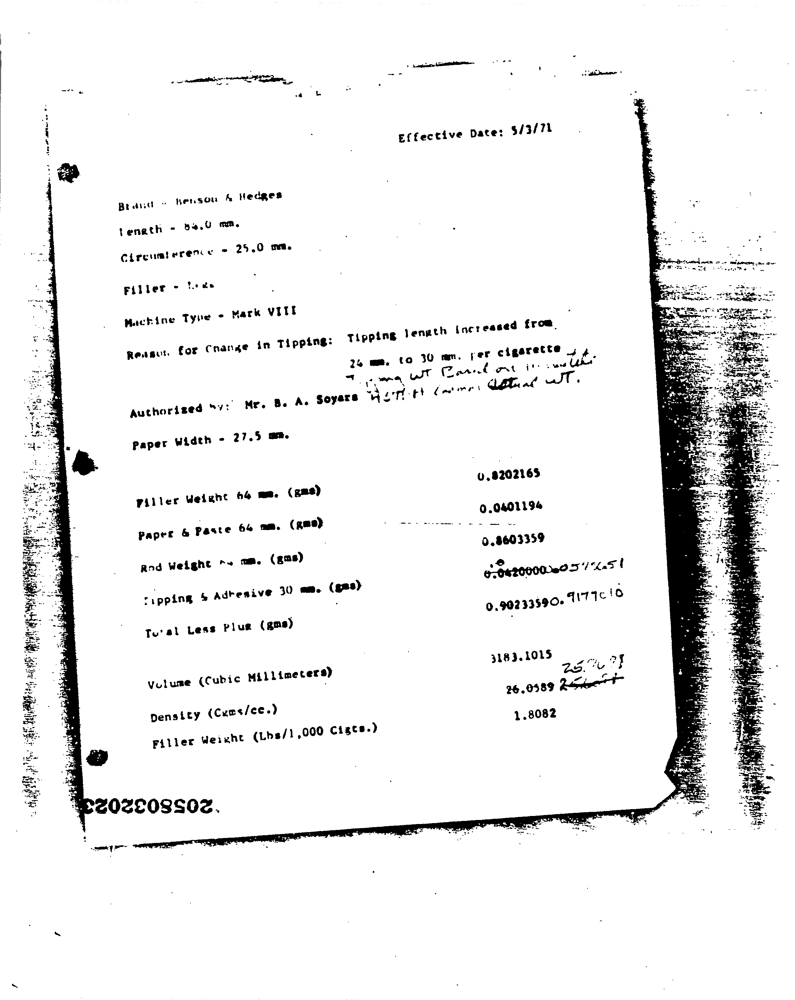
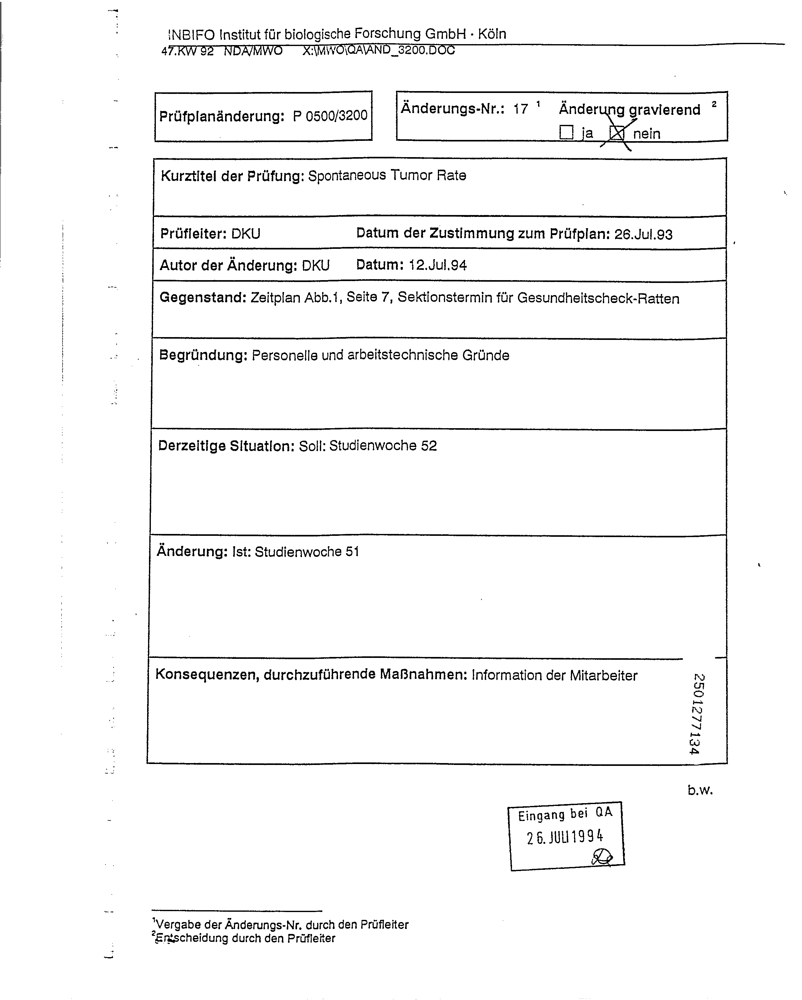
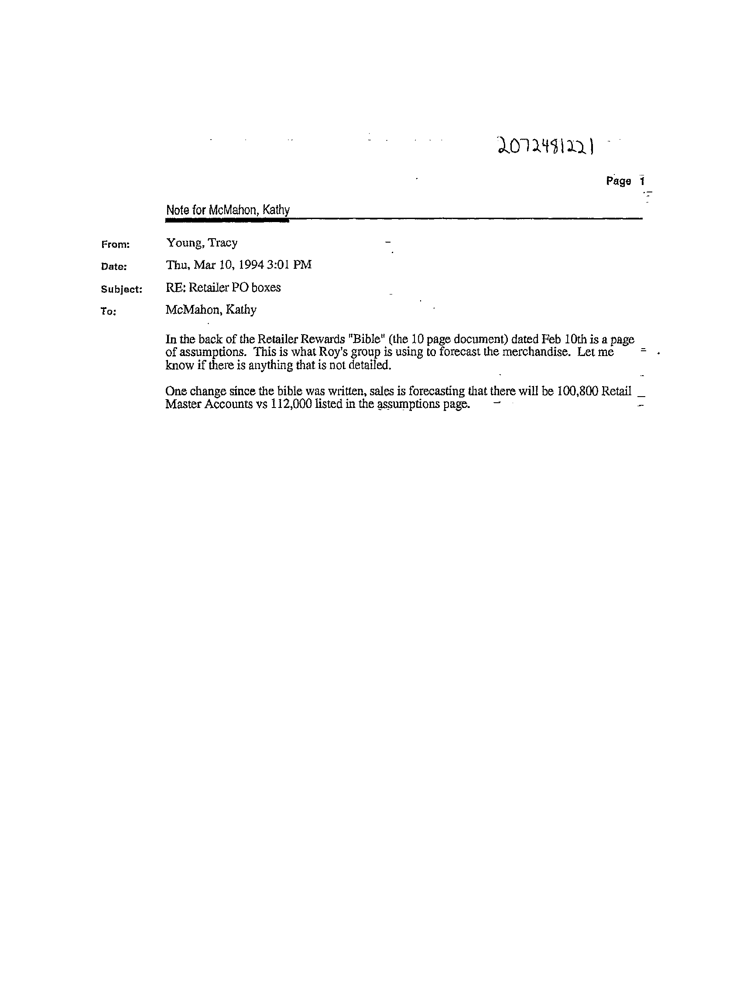
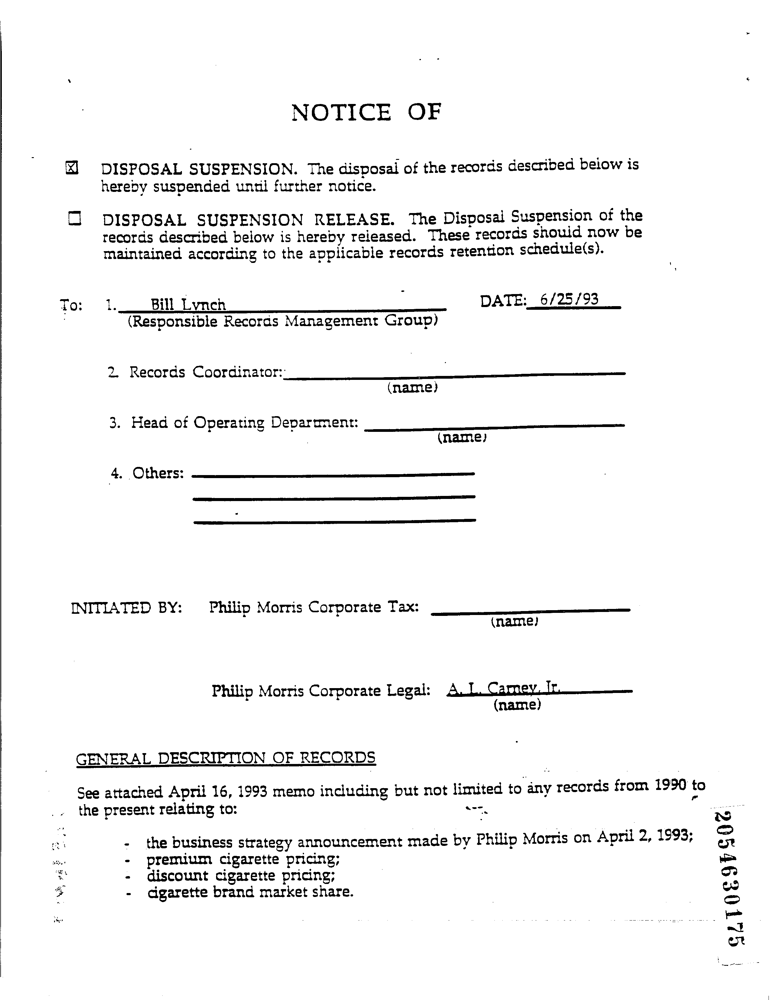


Searching for: '인사팀에서 보내온 복리후생 정책 변경 안내문이 있나?'



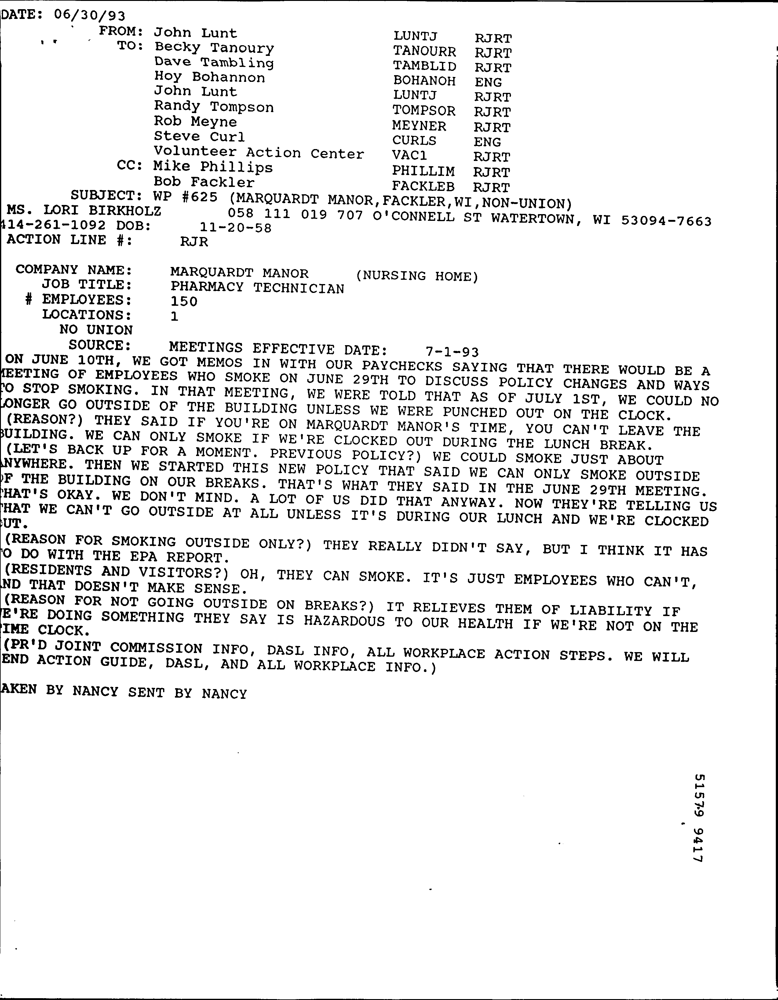
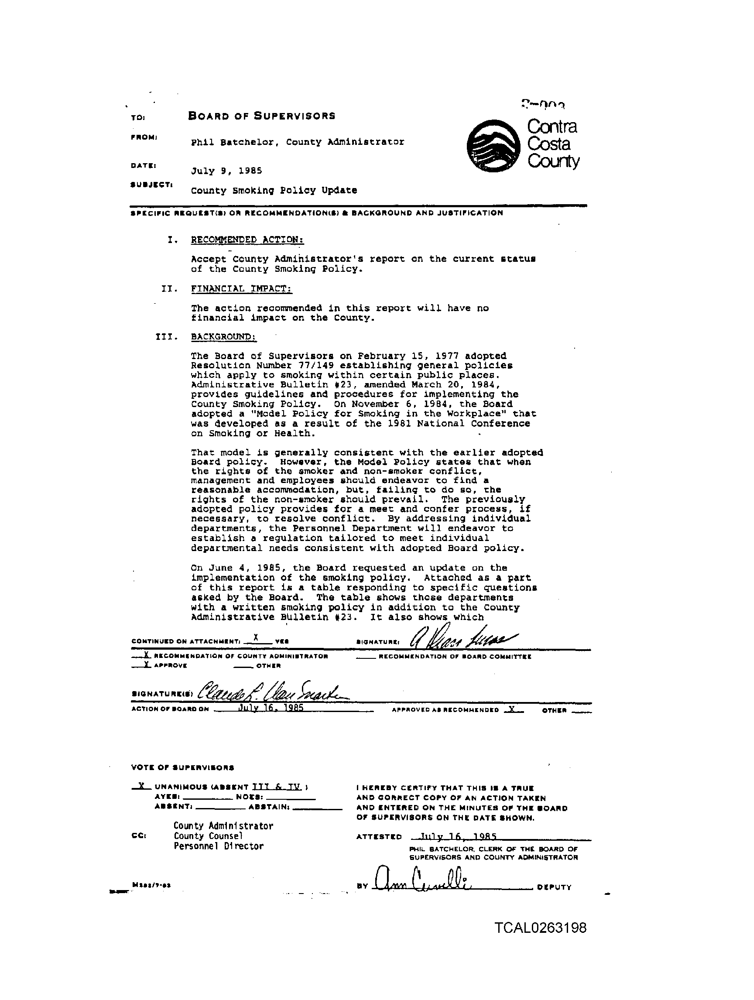
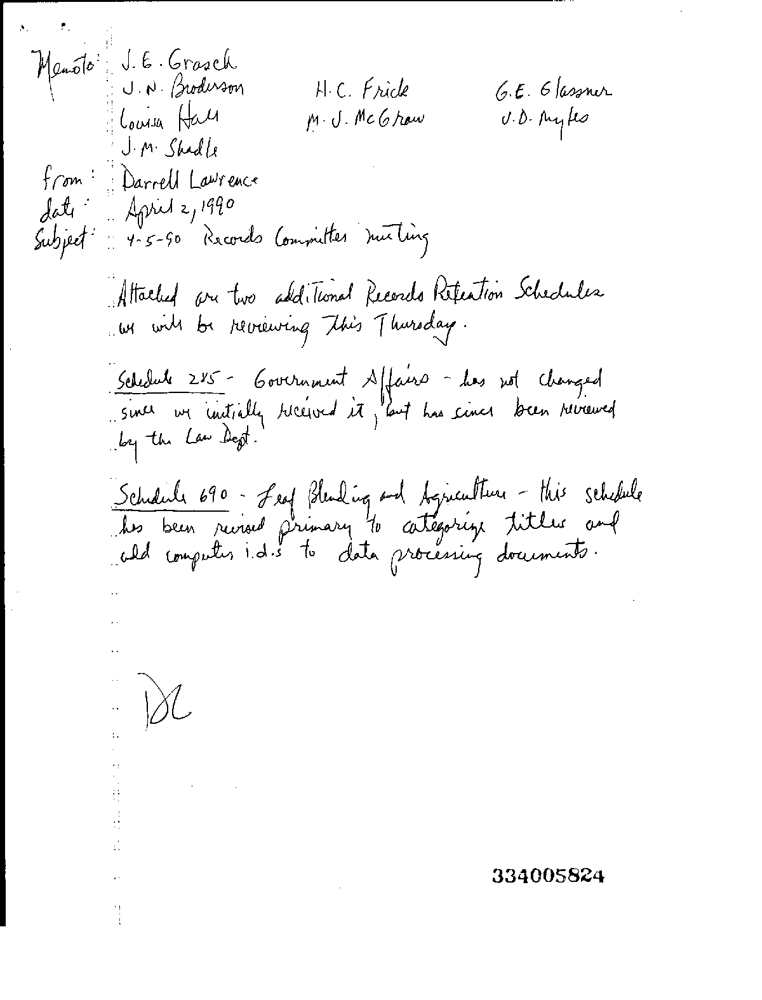
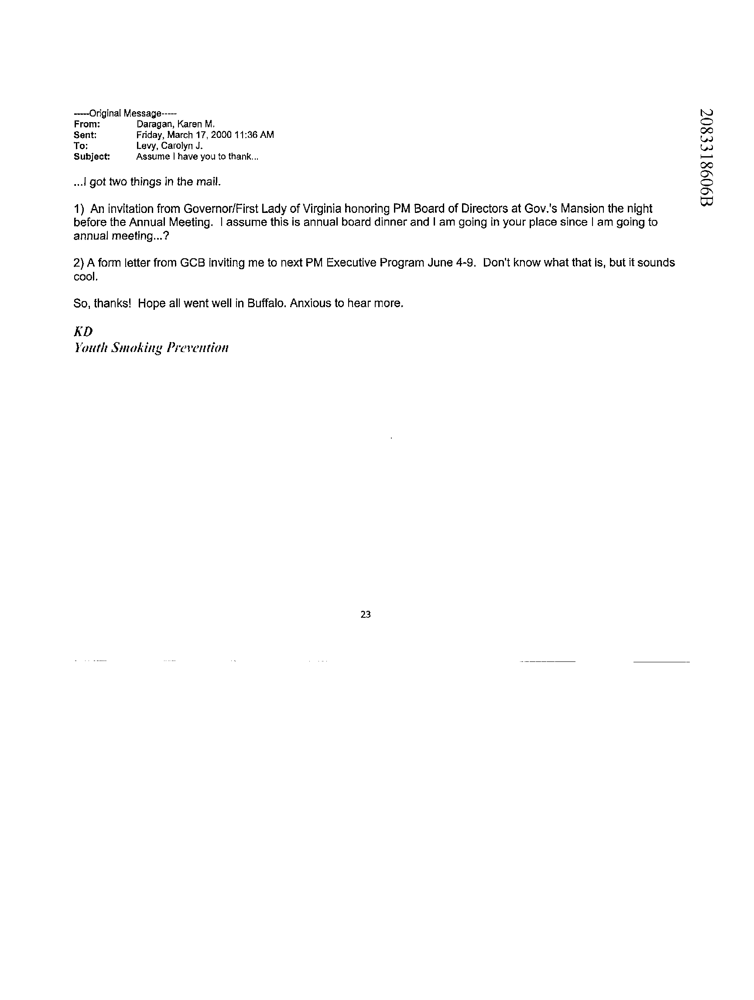
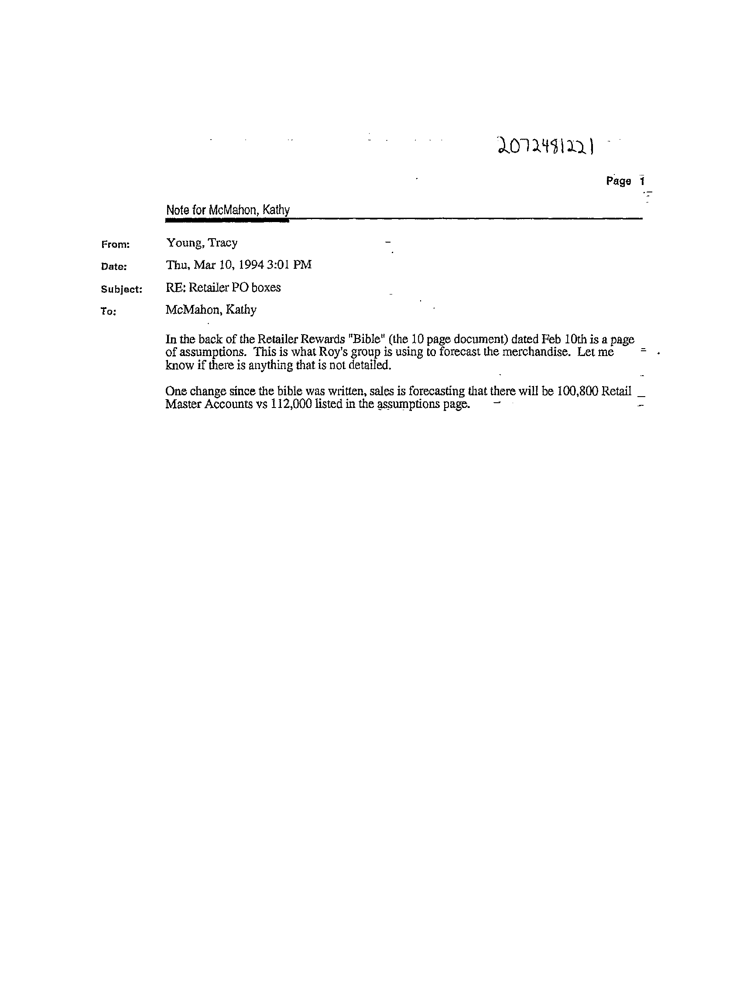


Searching for: 'Do you have any faxes from last July with handwritten notes?'



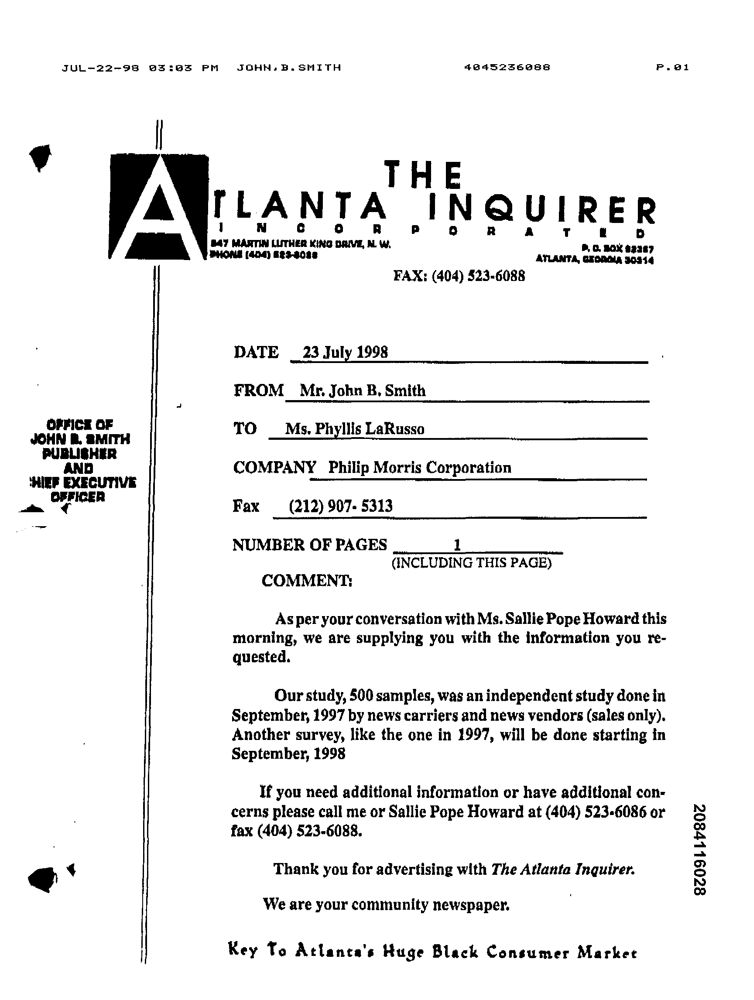
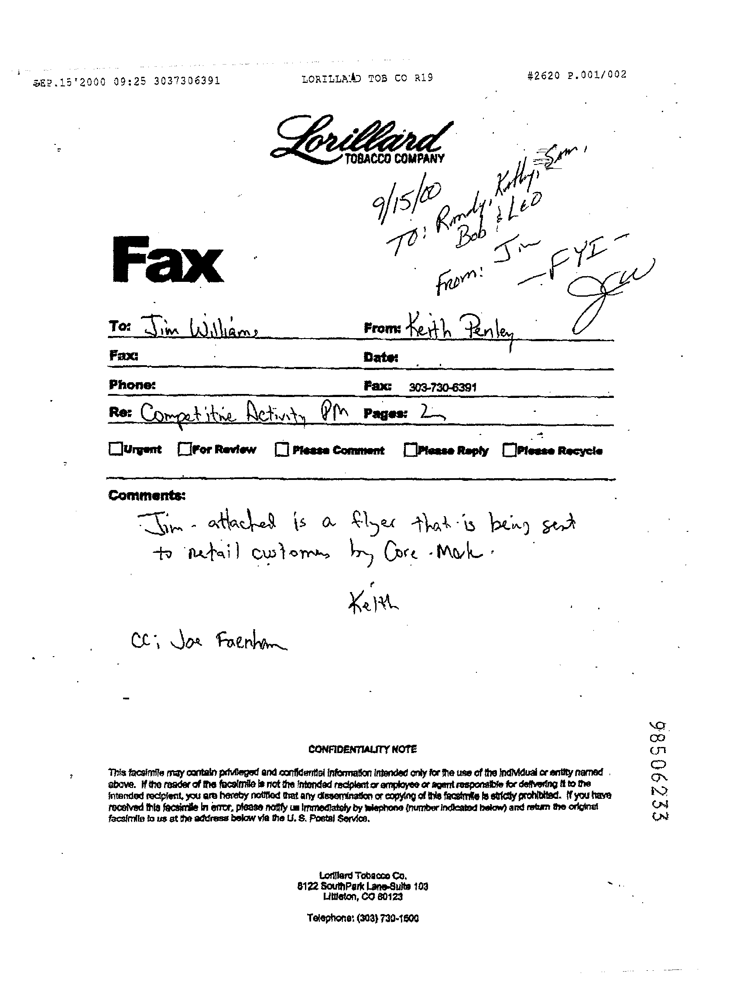
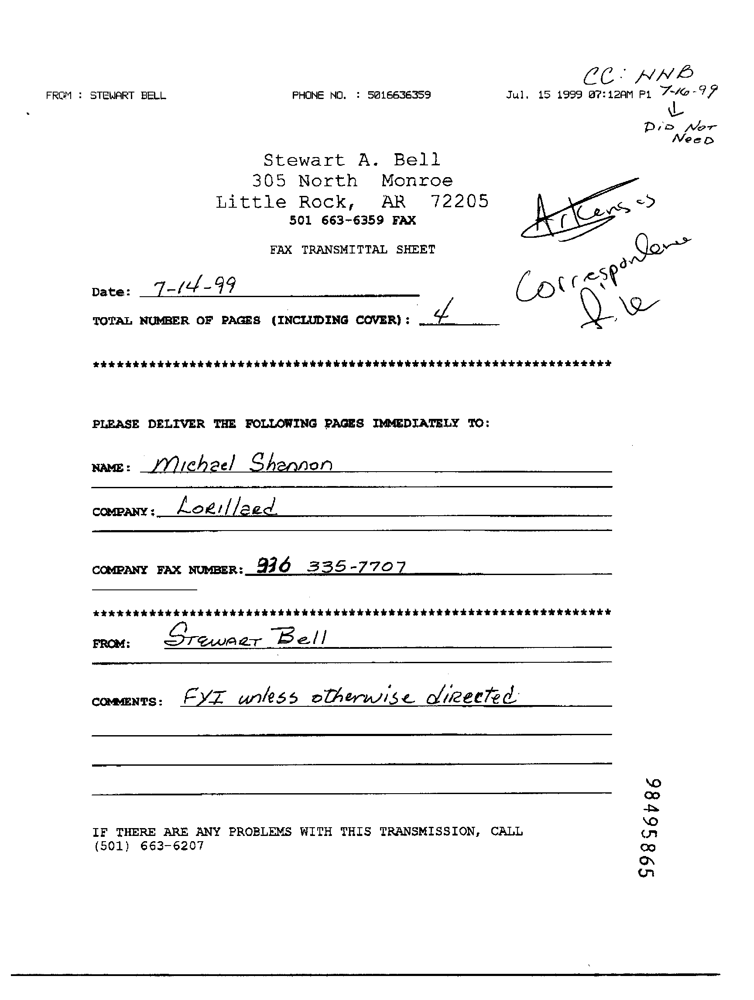
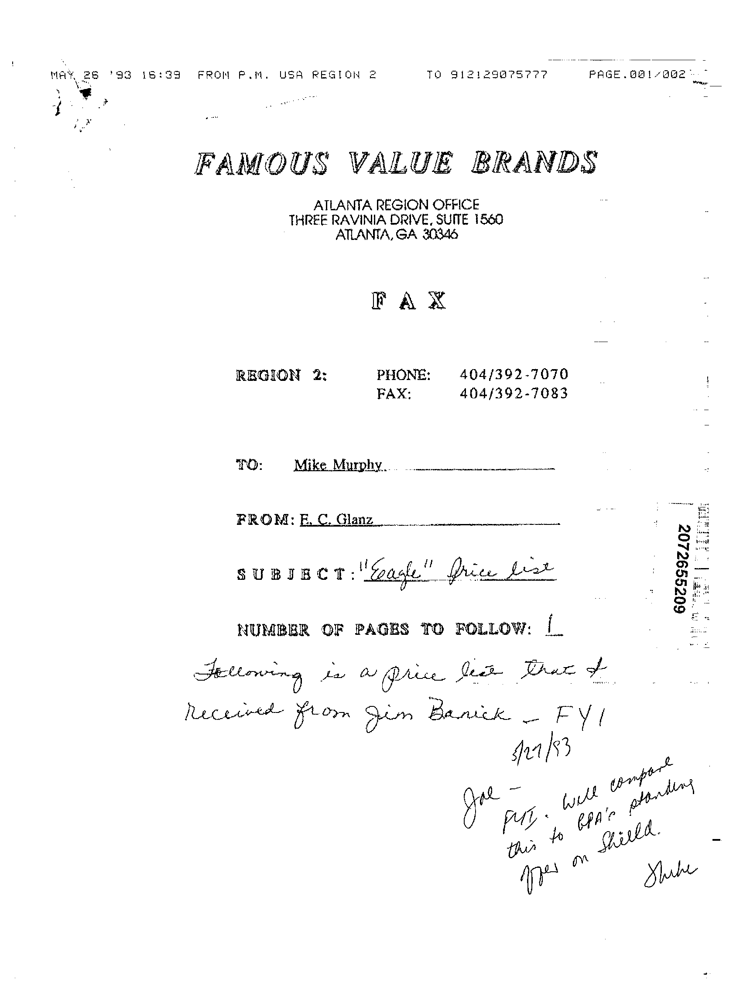
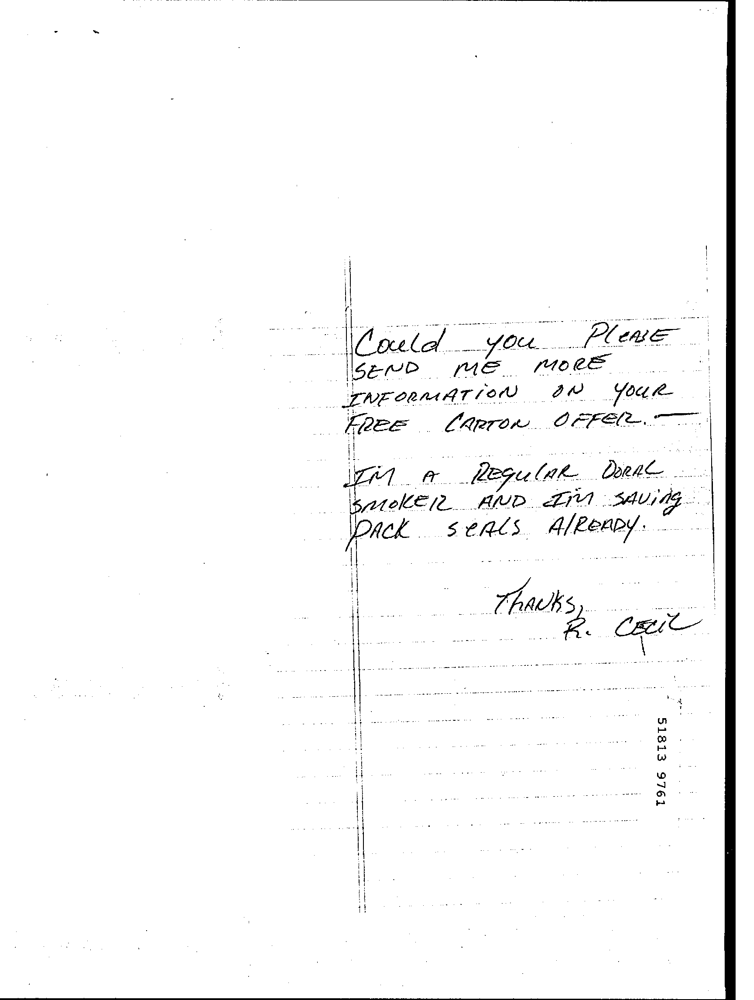


Searching for: '지난 7월에 보낸 팩스 중에서 필기체로 메모된 게 있어?'



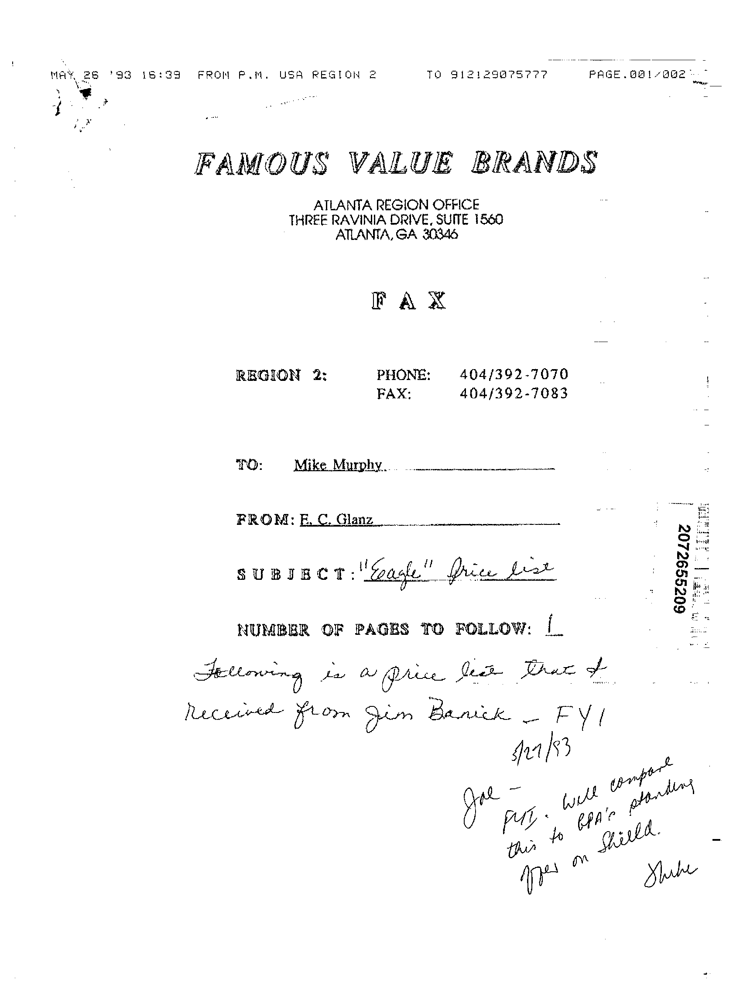
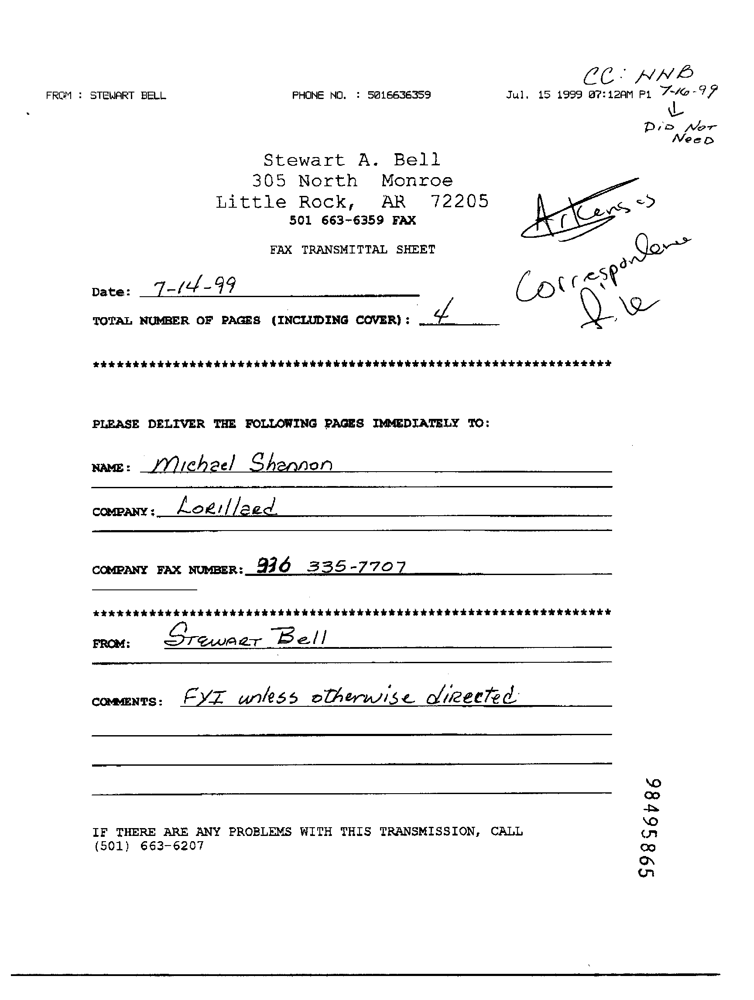
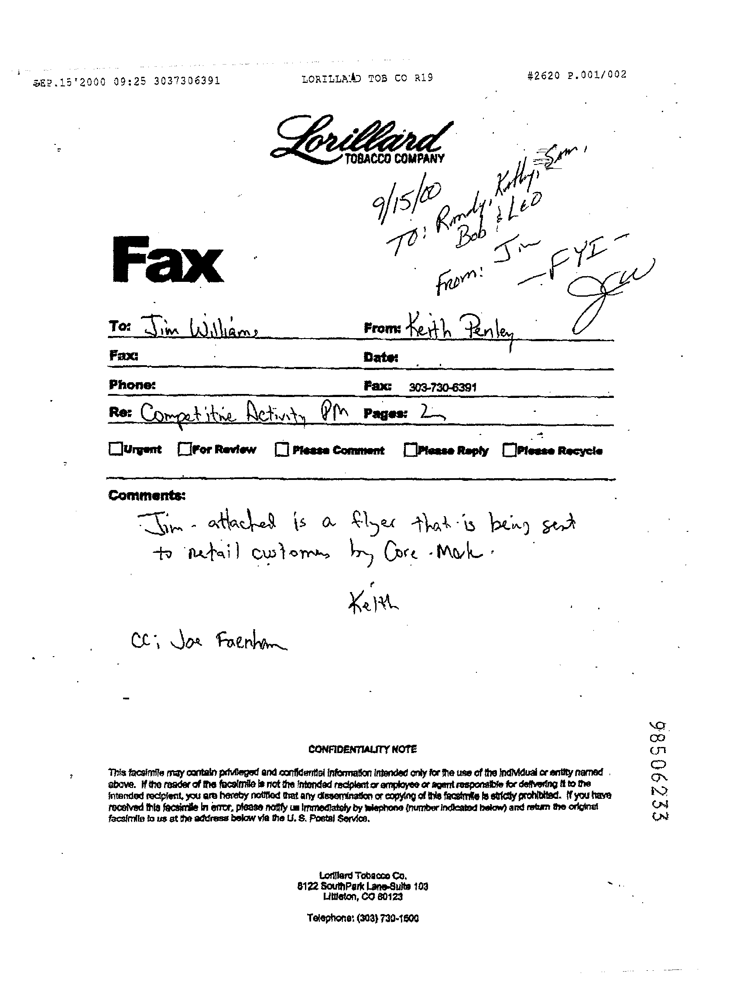
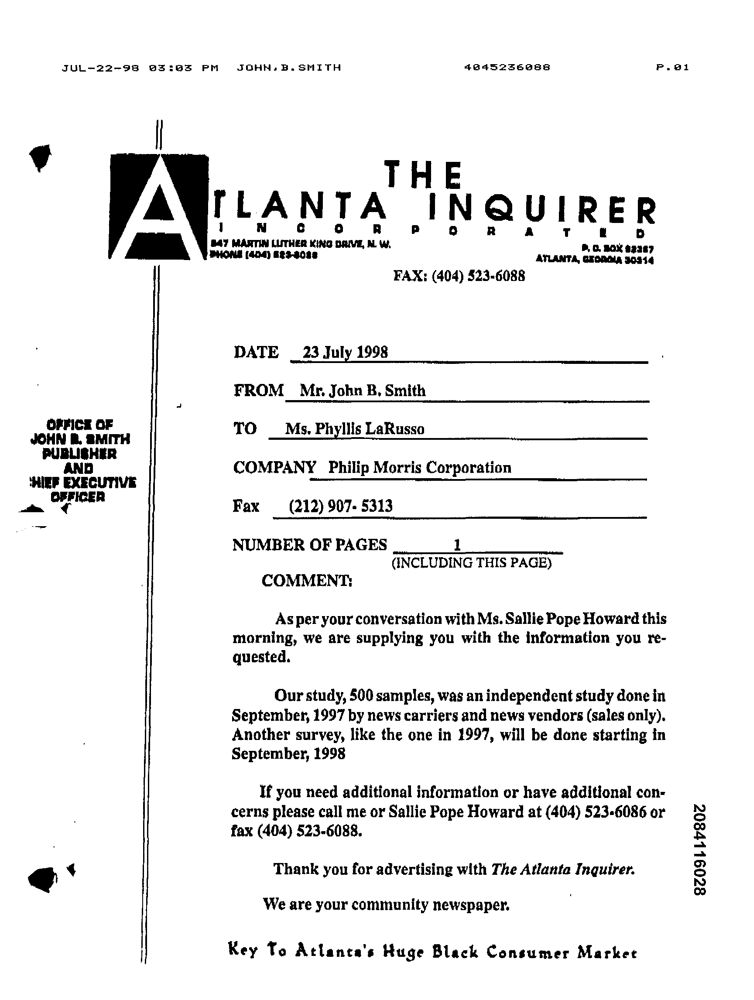
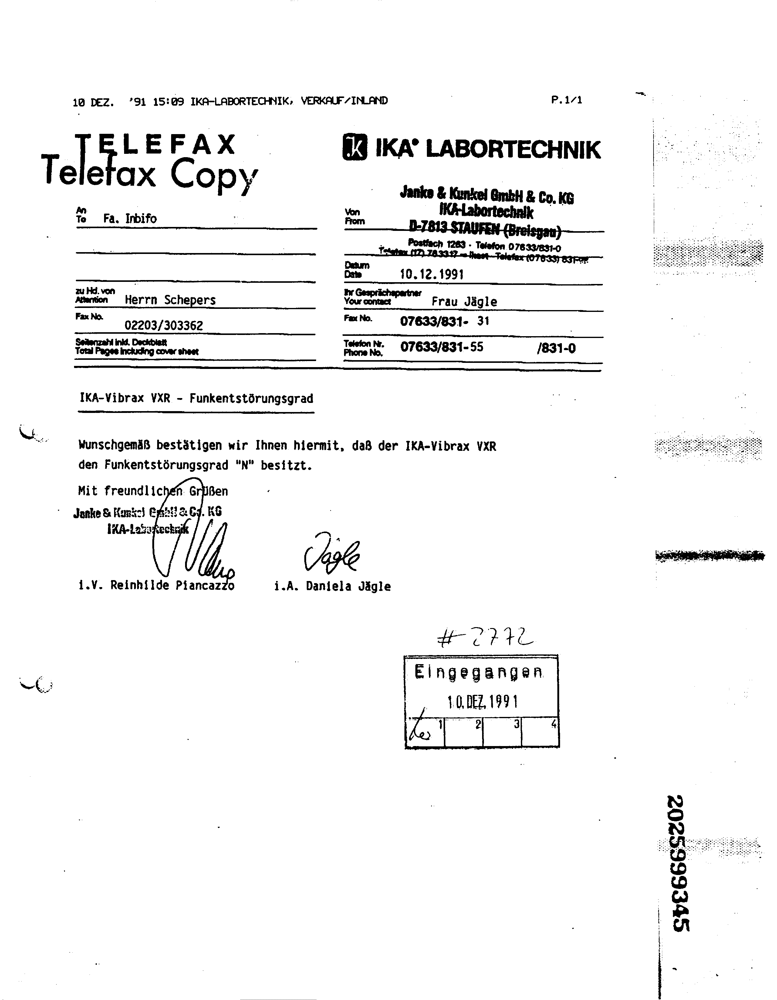


Searching for: 'Show me the receipt you received after purchasing a product that shows the tax line item'



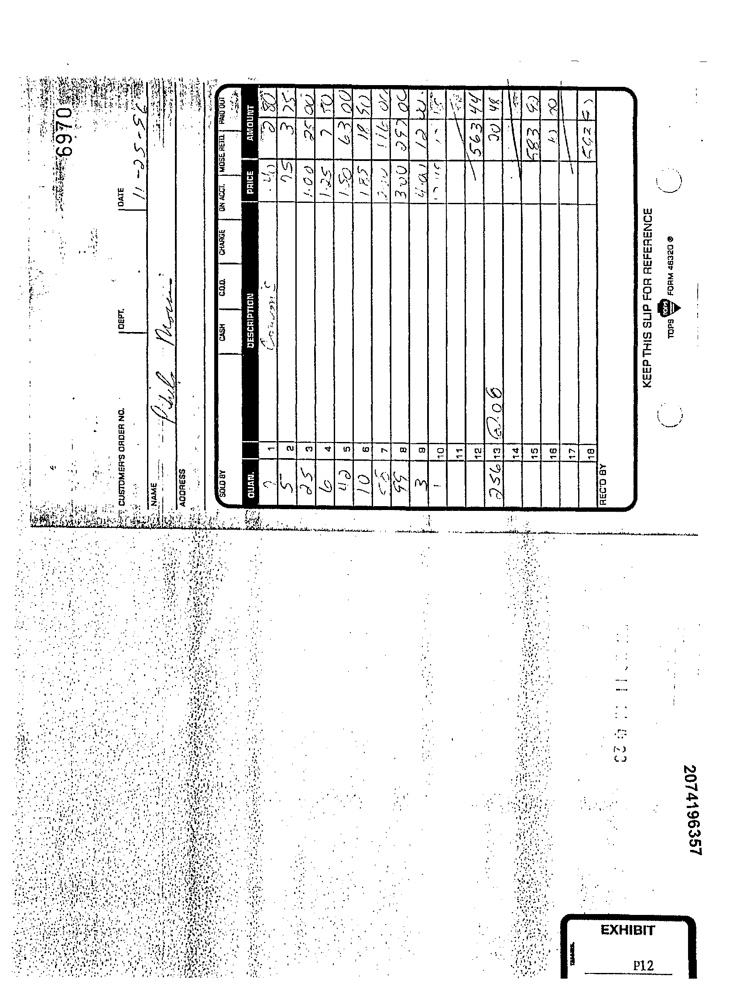
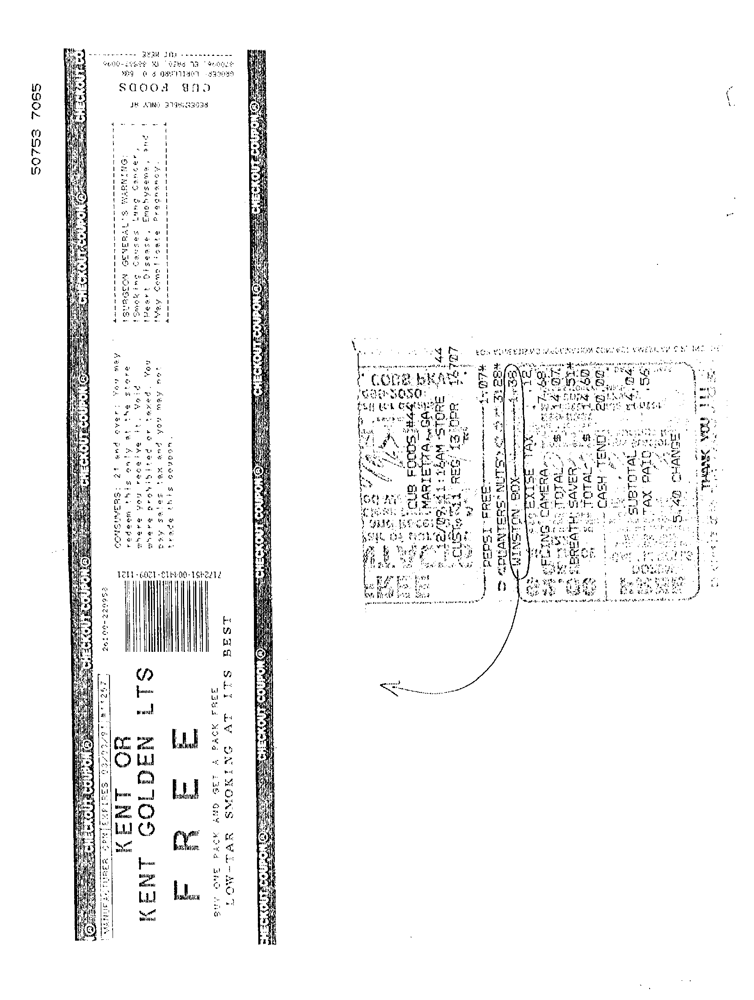
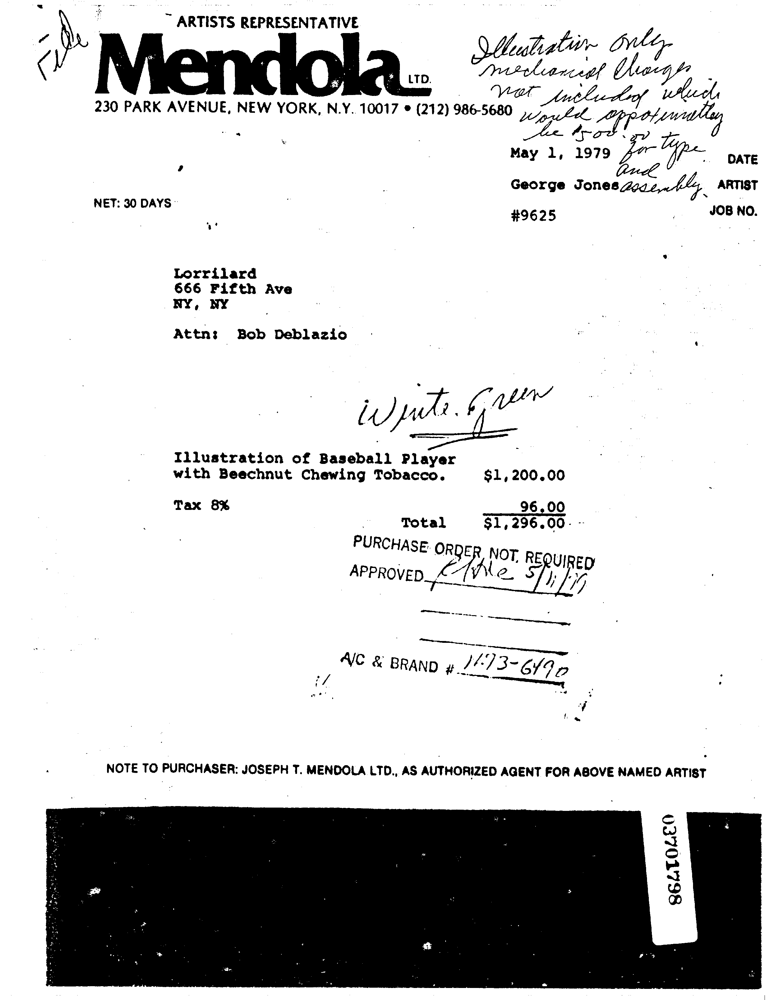
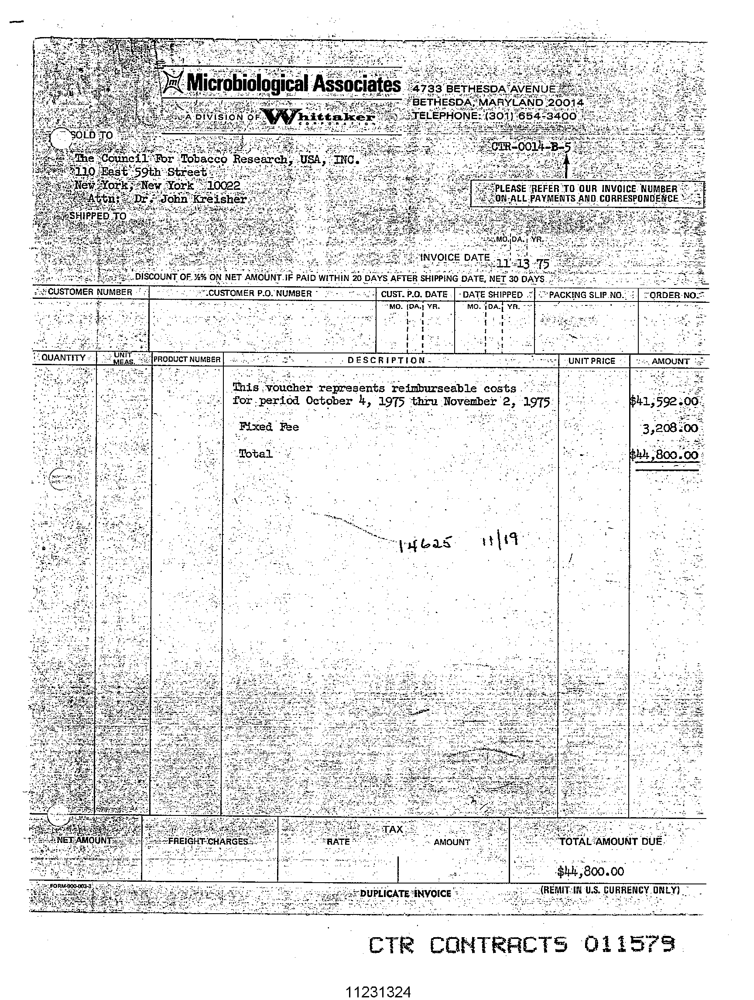
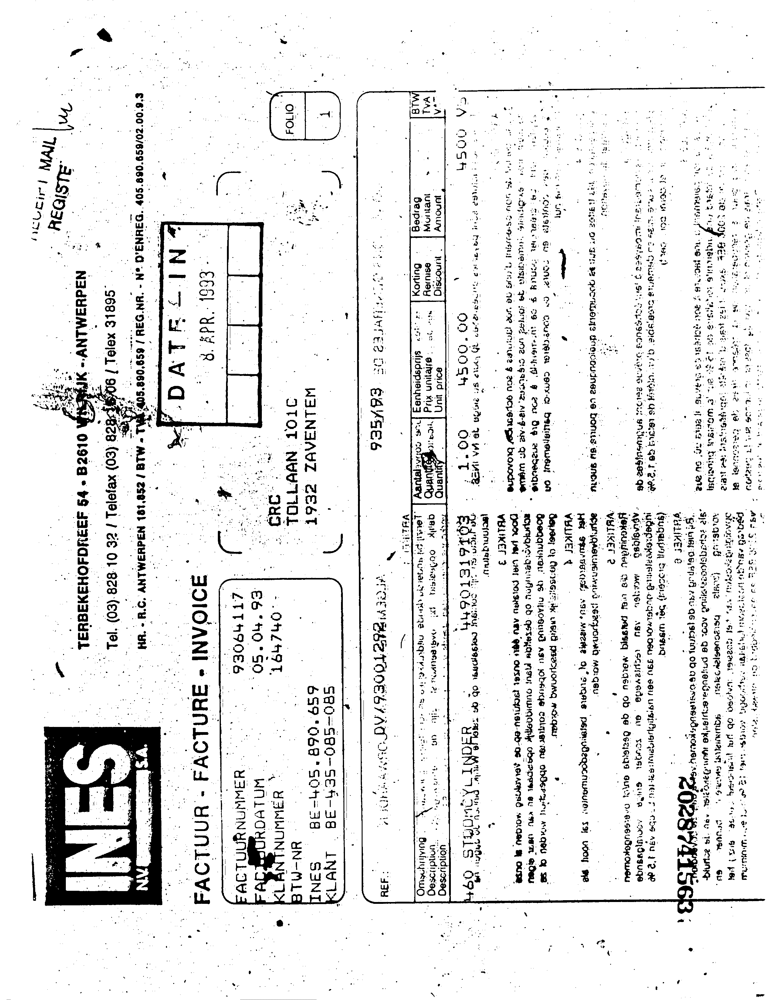


Searching for: '제품 구매 후 받은 영수증 중 세금 항목이 적힌 걸 보여줘'



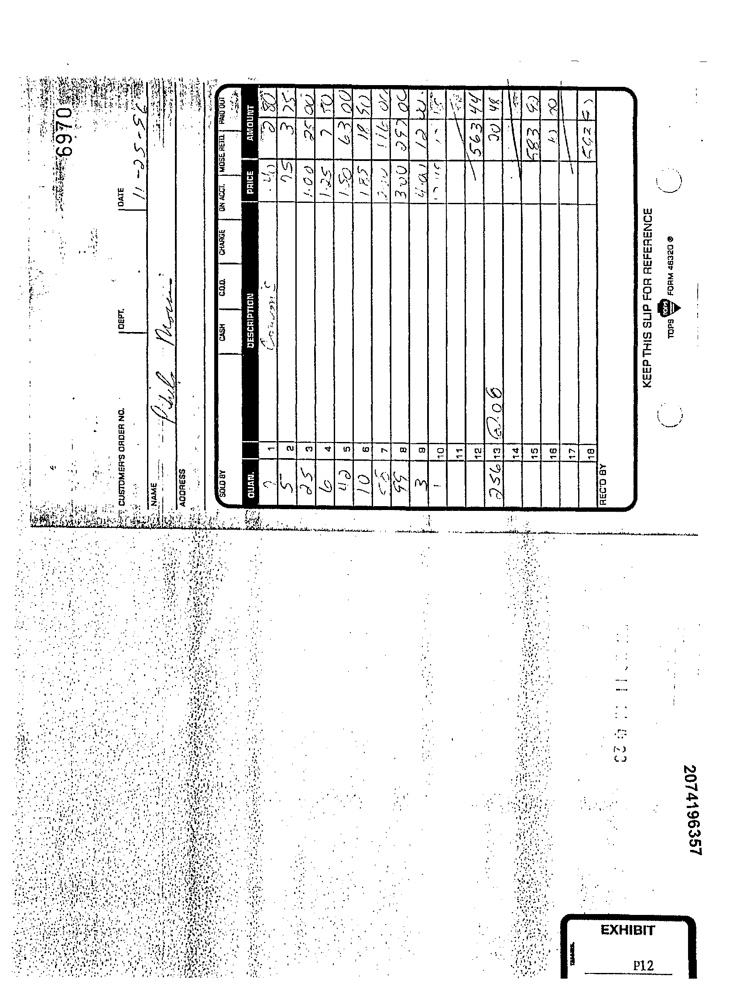
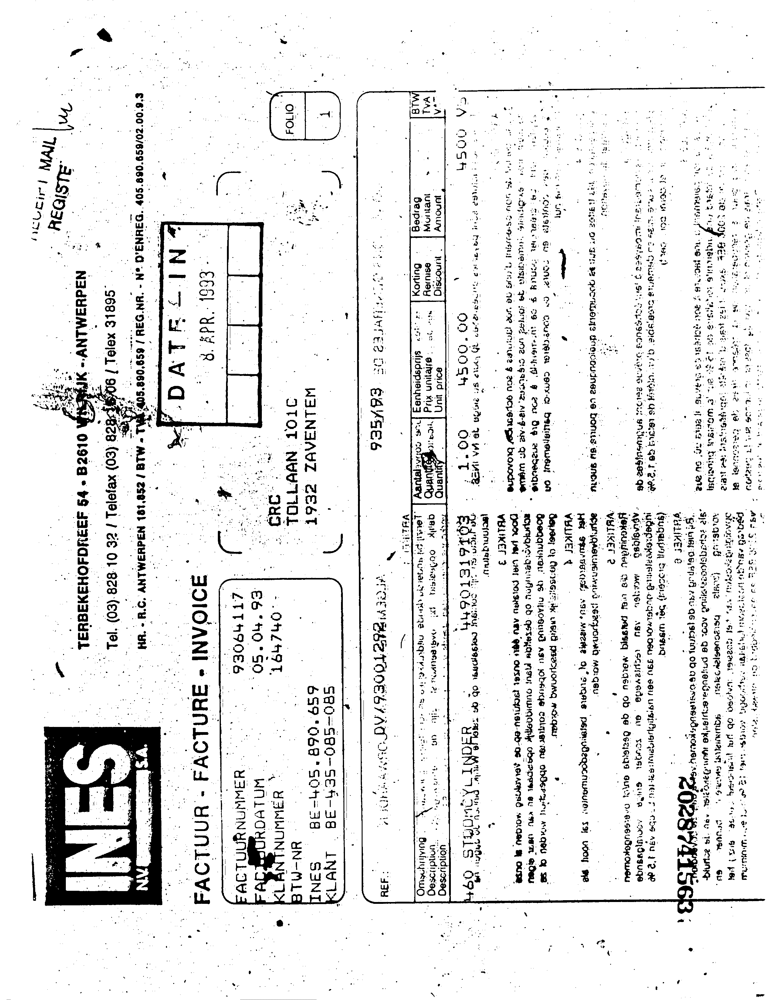
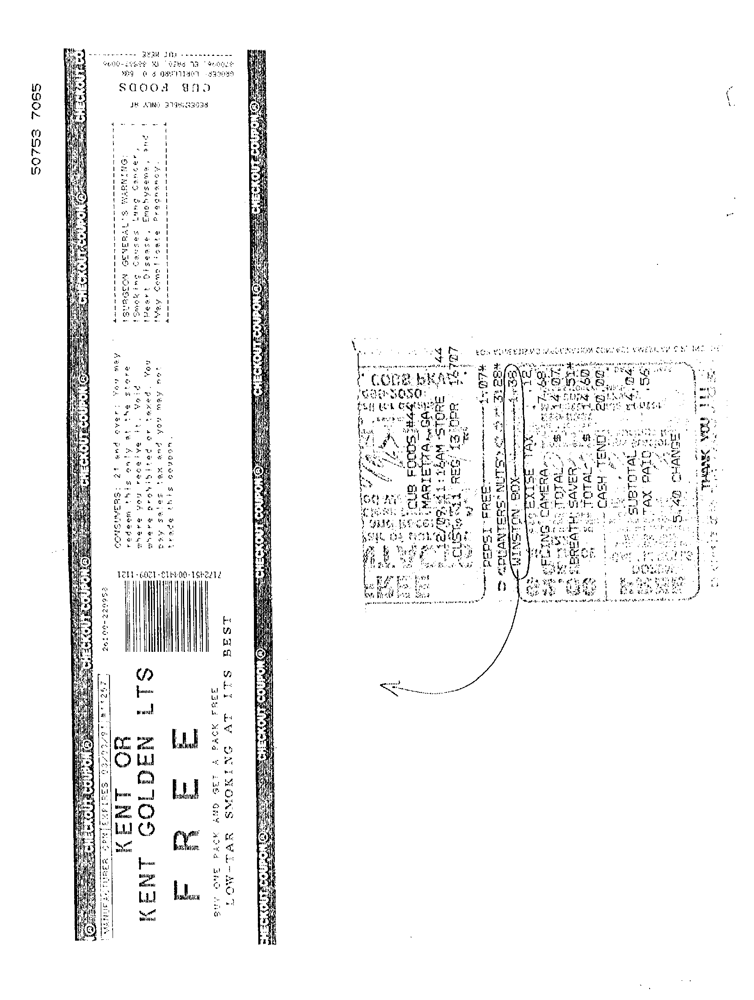
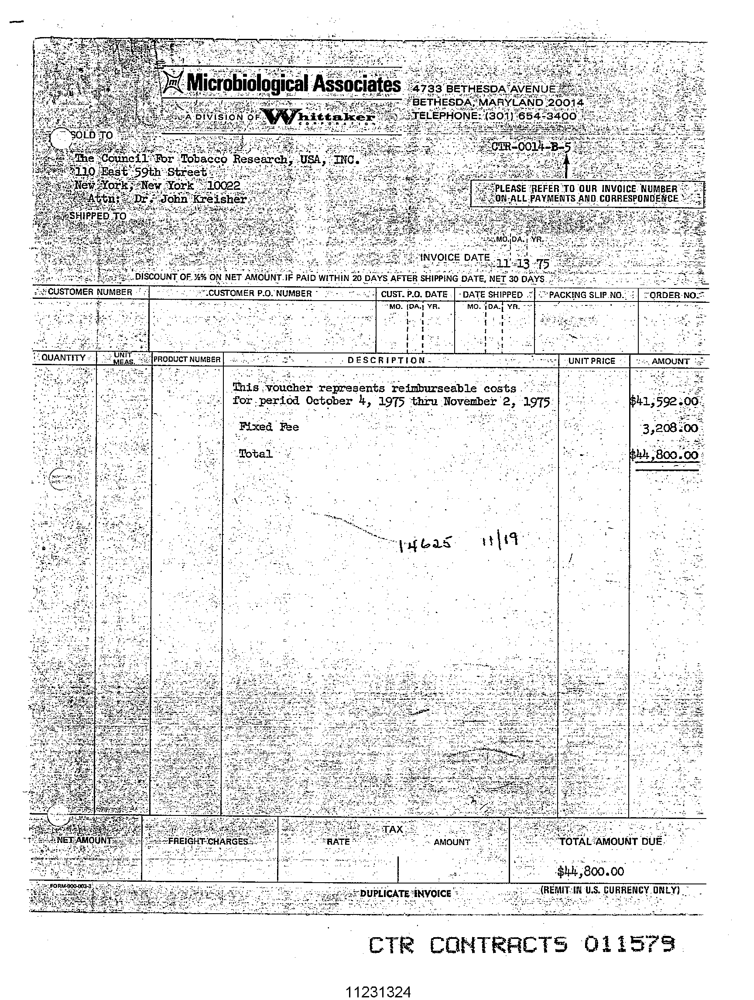
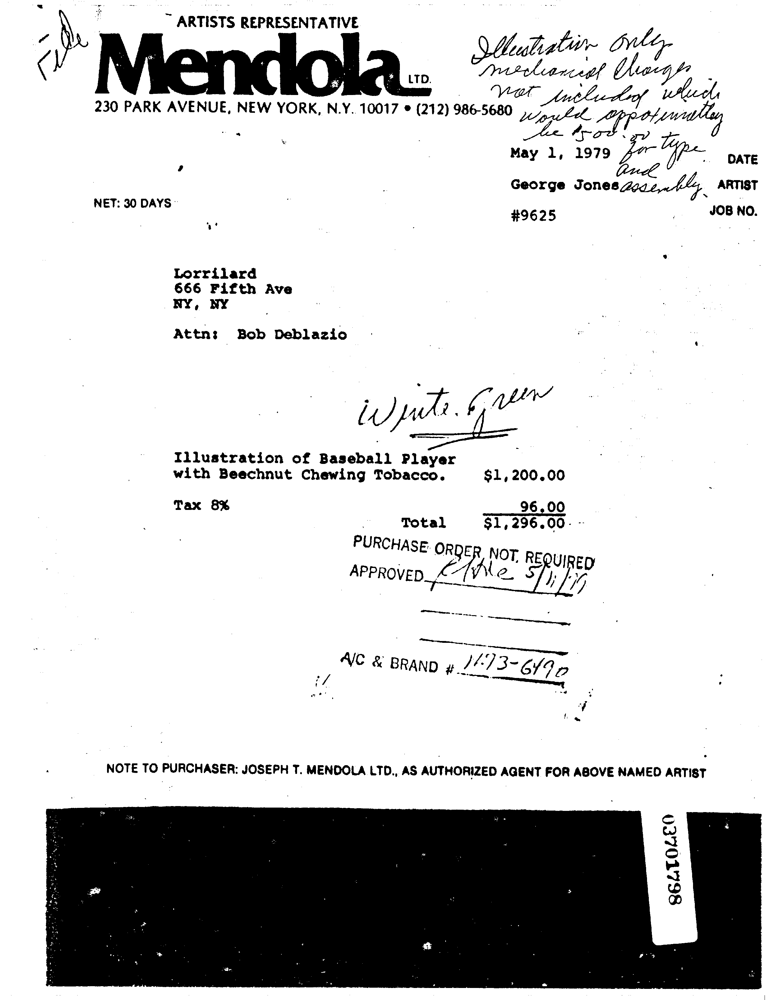

In [23]:
def search_and_display(query, es_client):
    print(f"\nSearching for: '{query}'")
    query_vectors = create_colqwen_query_vectors(query)
    
    es_query = {
        "_source": ["image_path", "category"],
        "query": {
            "script_score": {
                "query": {"match_all": {}},
                "script": {
                    "source": f"maxSimDotProduct(params.query_vector, '{VECTOR_FIELD_NAME}')",
                    "params": {"query_vector": query_vectors},
                },
            }
        },
        "size": 5,
    }
    
    results = es_client.search(index=INDEX_NAME, body=es_query)
    
    html = "<table><tr>"
    for hit in results["hits"]["hits"]:
        doc_id = hit["_id"]
        score = hit["_score"]
        path = hit["_source"]["image_path"]
        category = hit["_source"]["category"]
        try:
            with open(path, "rb") as image_file:
                img_str = base64.b64encode(image_file.read()).decode()
                html += f"""
                <td style='text-align: center; vertical-align: top; padding: 10px; border: 1px solid #ddd;'>
                    <img src='data:image/png;base64,{img_str}' width='200'><br>
                    <b>ID:</b> {doc_id}<br>
                    <b>Score:</b> {score:.4f}<br>
                    <b>Category:</b> {category}
                </td>
                """
        except Exception as e:
            print(f"Could not display image {path}: {e}")
    html += "</tr></table>"
    
    if results["hits"]["hits"]:
        display(HTML(html))
    else:
        print("No results found.")

# Perform a series of searches to demonstrate the model's capabilities.
search_and_display("Do you have a benefits policy change notice from HR?", es)
search_and_display("인사팀에서 보내온 복리후생 정책 변경 안내문이 있나?", es)
search_and_display("Do you have any faxes from last July with handwritten notes?", es)
search_and_display("지난 7월에 보낸 팩스 중에서 필기체로 메모된 게 있어?", es)
search_and_display("Show me the receipt you received after purchasing a product that shows the tax line item", es)
search_and_display("제품 구매 후 받은 영수증 중 세금 항목이 적힌 걸 보여줘", es)

### Step 8: Free up Memory

**[EN]** We forcefully shut down the kernel to free up the memory used by the model.<br>
**[KR]** 모델이 사용한 메모리를 해제하기 위해 커널을 강제로 종료합니다.

In [ ]:
# We kill the kernel forcefully to free up the memory from the model.
print("Shutting down the kernel to free memory...")
import os

os._exit(0)